## **Mount implementation folder in google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/FYP/Implementation/data
! ls

/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data
encoded-data.csv	preprosessing-dos.csv	  UNSW-NB15_1.csv
NUSW-NB15_features.csv	selected_columns_all.csv  UNSW-NB15_2.csv
OTset.csv		SVR-predict-data.csv	  UNSW-NB15_3.csv
preprocessing.csv	testset.csv		  UNSW-NB15_4.csv


## **Load balanced training datset for DOS attacks**

Data = (x_train, y_train)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

#get select columns for training
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)
col=list(select_col['Reconnaissance'])


#create training dataset down sampling
df = pd.read_csv('encoded-data.csv', sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']


Exploits_attacks = df[df['Reconnaissance'] == 1]
Normal_Data = df[df['Label'] == 0]
frames = [Exploits_attacks, Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=attack_labels, axis=1)
Y=result[['Reconnaissance']]
X.head()

undersample = RandomUnderSampler(random_state=0)
# fit and apply the transform
X, Y = undersample.fit_resample(X,Y)


x_train,y_train  = shuffle(X[col],Y)


X_train_normalized = preprocessing.normalize(x_train)
X_train_normalized 




array([[2.18032299e-03, 2.33069010e-03, 3.75917758e-04, ...,
        0.00000000e+00, 5.52599104e-02, 3.00734206e-04],
       [6.77336450e-05, 7.24049308e-05, 1.16782146e-05, ...,
        0.00000000e+00, 2.27258057e-03, 7.00692879e-06],
       [0.00000000e+00, 3.40178584e-06, 8.03571457e-08, ...,
        2.67857152e-08, 0.00000000e+00, 1.33928576e-08],
       ...,
       [2.72762837e-03, 2.91574067e-03, 4.70280754e-04, ...,
        0.00000000e+00, 5.31417252e-02, 1.88112302e-04],
       [5.98847411e-06, 6.40147232e-06, 1.03249554e-06, ...,
        0.00000000e+00, 4.70817964e-05, 4.12998214e-07],
       [2.31145187e-03, 2.47086235e-03, 3.98526185e-04, ...,
        0.00000000e+00, 4.50334589e-02, 2.39115711e-04]])

## **Create Test Set for DOS attacks**

Data = (x_test_DOS_normalized, y_test)

In [4]:
import pandas as pd
import numpy as np
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)

columns=list(select_col['Reconnaissance'])

test_data =pd.read_csv("testset.csv", sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']
attack_categories = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] 

Exploits_attacks  = test_data[test_data['attack_cat'] == 'Reconnaissance']
# print(DoS_attacks.shape)
Normal_Data = test_data[test_data['Label'] == 0]
# print(Normal_Data.shape)

frames = [Exploits_attacks , Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=['attack_cat', 'Label'], axis=1)
Y=result[['Label']]
X.head()

x_test,y_test  = shuffle(X[columns],Y)

x_test = x_test.replace('-','')
x_test = x_test.replace(r'^\s*$', np.nan, regex=True)

#delete raws with missing values
for i in x_test.columns.values.tolist():
  i = x_test.loc[x_test[i].isnull()].index
  x_test = x_test.drop(index=list(i))
  y_test = y_test.drop(index=list(i))

percent_missing = x_test.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': x_test.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
# print(missing_value_df)

x_test.head()
#encode the data
from sklearn.preprocessing import LabelEncoder

# replace hex with int
# x_test['sport'] = x_test['sport'].astype(str).apply(int, base=16)
# x_test['dsport'] = x_test['dsport'].astype(str).apply(int, base=16)

# #Create an instance of Label-encoder
labelencoder = LabelEncoder() 

# # encode columns consists with strings
x_test['srcip'] = labelencoder.fit_transform(x_test['srcip'])
x_test['dstip'] = labelencoder.fit_transform(x_test['dstip'])
x_test['proto'] = labelencoder.fit_transform(x_test['proto'])
x_test['state'] = labelencoder.fit_transform(x_test['state'])

X_test_normalized = preprocessing.normalize(x_test) 


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Random Forrest Regression**

In [5]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


# Number of trees in random forest
n_estimators = [2, 4, 8, 16, 32, 64, 100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2,3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}




 # create regressor object
regressor = GridSearchCV(RandomForestRegressor(random_state=0),param_grid,return_train_score=False)

# fit the regressor with x and y data
regressor.fit(x, y)


df = pd.DataFrame(regressor.cv_results_)
df

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.045419,0.003194,0.001578,0.000067,True,2,auto,1,2,2,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.826521,0.787411,0.813605,0.795914,0.789130,0.802516,0.015167,247
1,0.085628,0.005929,0.001890,0.000038,True,2,auto,1,2,4,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.826352,0.788593,0.814288,0.796839,0.789956,0.803206,0.014752,199
2,0.214173,0.051325,0.003301,0.000566,True,2,auto,1,2,8,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.827456,0.788599,0.815286,0.797492,0.789484,0.803664,0.015279,193
3,0.344552,0.035222,0.004380,0.000909,True,2,auto,1,2,16,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.827399,0.788569,0.815892,0.797765,0.789950,0.803915,0.015253,187
4,0.645780,0.003331,0.006642,0.000108,True,2,auto,1,2,32,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.827861,0.788621,0.816111,0.798120,0.789394,0.804021,0.015495,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.111915,0.007751,0.003116,0.000340,False,4,sqrt,2,5,8,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.877908,0.883678,0.842831,0.842059,0.831521,0.855599,0.021035,160
332,0.213824,0.005016,0.005818,0.000860,False,4,sqrt,2,5,16,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.871124,0.872334,0.851234,0.842833,0.833464,0.854198,0.015384,165
333,0.425230,0.004509,0.008067,0.000158,False,4,sqrt,2,5,32,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.873054,0.879384,0.861960,0.856095,0.843636,0.862826,0.012595,132
334,0.826373,0.007380,0.014572,0.000227,False,4,sqrt,2,5,64,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.868313,0.874348,0.859541,0.850299,0.840625,0.858625,0.012126,150


In [6]:
df[['param_bootstrap', 	'param_max_depth', 	'param_max_features', 	'param_min_samples_leaf', 	'param_min_samples_split', 	'param_n_estimators','mean_test_score']]

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score
0,True,2,auto,1,2,2,0.802516
1,True,2,auto,1,2,4,0.803206
2,True,2,auto,1,2,8,0.803664
3,True,2,auto,1,2,16,0.803915
4,True,2,auto,1,2,32,0.804021
...,...,...,...,...,...,...,...
331,False,4,sqrt,2,5,8,0.855599
332,False,4,sqrt,2,5,16,0.854198
333,False,4,sqrt,2,5,32,0.862826
334,False,4,sqrt,2,5,64,0.858625


In [7]:
regressor.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 4}

**Train the model**

In [8]:
from sklearn.ensemble import RandomForestRegressor

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


 # create regressor object
regressor = RandomForestRegressor(bootstrap=True,max_depth=4,max_features= 'auto',min_samples_leaf=1,min_samples_split=2,n_estimators=4)

# fit the regressor with x and y data
regressor.fit(x, y)

y_pred = regressor.predict(x)


<ipython-input-8-3f03917afd62>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x, y)


In [9]:
from sklearn.metrics import accuracy_score

for i in range(1,100):
  y_predict_class = [1 if p > i/100 else 0 for p in y_pred]
  print("Accuracy when threshould = ",i/100, round(accuracy_score(y, y_predict_class), 6))

Accuracy when threshould =  0.01 0.939408
Accuracy when threshould =  0.02 0.939408
Accuracy when threshould =  0.03 0.96994
Accuracy when threshould =  0.04 0.972592
Accuracy when threshould =  0.05 0.972592
Accuracy when threshould =  0.06 0.973358
Accuracy when threshould =  0.07 0.973358
Accuracy when threshould =  0.08 0.973358
Accuracy when threshould =  0.09 0.973358
Accuracy when threshould =  0.1 0.973358
Accuracy when threshould =  0.11 0.973358
Accuracy when threshould =  0.12 0.973712
Accuracy when threshould =  0.13 0.973712
Accuracy when threshould =  0.14 0.973712
Accuracy when threshould =  0.15 0.973712
Accuracy when threshould =  0.16 0.973712
Accuracy when threshould =  0.17 0.973948
Accuracy when threshould =  0.18 0.973948
Accuracy when threshould =  0.19 0.973948
Accuracy when threshould =  0.2 0.973948
Accuracy when threshould =  0.21 0.973948
Accuracy when threshould =  0.22 0.973948
Accuracy when threshould =  0.23 0.974302
Accuracy when threshould =  0.24 0.97

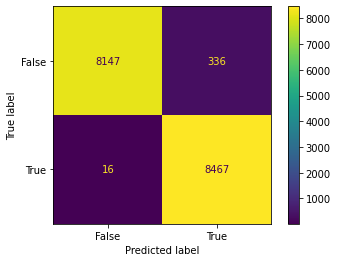

In [10]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

threshould =0.5

y_predict_class = [1 if p > threshould else 0 for p in y_pred]
confusion_matrix = metrics.confusion_matrix(y, y_predict_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 


**Test Set Accuracy**

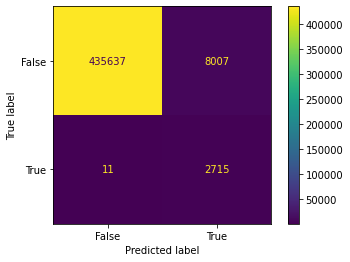

Accuracy when threshould =  0.6 0.982037


In [12]:
x_test_array = np.array(X_test_normalized)
y_test_array = np.array(y_test)
y_pred_test_set = regressor.predict(x_test_array)


threshould =0.6


y_predict_test_set_class = [1 if p > threshould else 0 for p in y_pred_test_set]
confusion_matrix = metrics.confusion_matrix(y_test_array, y_predict_test_set_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

print("Accuracy when threshould = ",threshould, round(accuracy_score(y_test_array, y_predict_test_set_class), 6))